In [217]:
import matplotlib.pyplot as plt
import numpy as np
import spacy
from spacy.matcher import DependencyMatcher
from spacy.displacy import parse_deps
import spacy.displacy as displacy
import sys
import tqdm
import random

from shared import tqdm_readlines

In [218]:
deu_nlp = spacy.load("de_zdl_lg")
rus_nlp = spacy.load("ru_core_news_md")

In [219]:
eng_snts = dict([(ln.strip().split("\t")[0], ln.strip().split("\t")[1]) for ln in tqdm_readlines("../data/tatoeba/eng.tsv")])

links = [ln.strip().split(",") for ln in tqdm_readlines("../data/tatoeba/links.csv")]

100%|████████████████████████████████████████████████████| 2689446/2689446 [00:04<00:00, 575881.85it/s]


In [302]:
deu_snts = dict([(ln.strip().split("\t")[0], deu_nlp(ln.strip().split("\t")[1])) for (ln, _) in zip(tqdm_readlines("../data/tatoeba/deu.tsv"), range(10000))])
rus_snts = dict([(ln.strip().split("\t")[0], rus_nlp(ln.strip().split("\t")[1])) for (ln, _) in zip(tqdm_readlines("../data/tatoeba/rus.tsv"), range(200000))])

 35%|███████████████████▋                                     | 200000/579156 [10:36<20:05, 314.43it/s]


In [303]:
eng_rus_pairs = [(eng_snts[l[0]], rus_snts[l[1]]) for r in links for l in [(r[0], r[1]), (r[1], r[0])] if l[0] in eng_snts if l[1] in rus_snts]

In [304]:
rus_freqlist = [ln.strip().split("\t")[1].replace("'", "") for ln in list(open("../resources/russian-freqlist.tsv").readlines())[1:] if len(ln) > 0]
rus_freqlist[:20]

['и',
 'в',
 'не',
 'на',
 'я',
 'быть',
 'с',
 'он',
 'что',
 'а',
 'это',
 'этот',
 'по',
 'к',
 'но',
 'они',
 'мы',
 'она',
 'как',
 'то']

In [305]:
s = eng_rus_pairs[5003][1]
# len(eng_rus_pairs)

print(sorted(list(set([t.dep_ for sp in eng_rus_pairs for t in sp[1]]))))

['ROOT', 'acl', 'acl:relcl', 'advcl', 'advmod', 'amod', 'appos', 'aux', 'aux:pass', 'case', 'cc', 'ccomp', 'compound', 'conj', 'cop', 'csubj', 'csubj:pass', 'dep', 'det', 'discourse', 'expl', 'fixed', 'flat', 'flat:foreign', 'flat:name', 'iobj', 'mark', 'nmod', 'nsubj', 'nsubj:pass', 'nummod', 'nummod:entity', 'nummod:gov', 'obj', 'obl', 'obl:agent', 'orphan', 'parataxis', 'punct', 'xcomp']


In [306]:
def ls_get(ls, i, default=None):
    if len(ls) > i:
        return ls[i]
    else:
        return default

def sigmoid(x):
    return 1/(1 + np.exp(-x))

In [307]:
def feature_vec_for_attr(w_nlp, get_attr, values):
    attr_val = get_attr(w_nlp)
    v = np.zeros(len(values))
    if attr_val in values:
        v[values.index(attr_val)] += 1
    return v

RUS_FEATURES = [
    {
        "name": "POS",
        "lambda": lambda w: w.pos_,
        "values": ['ADJ', 'ADP', 'ADV', 'AUX', 'CCONJ', 'DET', 'INTJ', 'NOUN', 'NUM', 'PART', 'PRON', 'PROPN', 'SCONJ', 'VERB']
    },
    {
        "name": "Number",
        "lambda": lambda w: ls_get(w.morph.get("Number"), 0),
        "values": ["Sing", "Plur"]
    },
    {
        "name": "Person",
        "lambda": lambda w: ls_get(w.morph.get("Person"), 0),
        "values": ["First", "Second", "Third"]
    },
    {
        "name": "Case",
        "lambda": lambda w: ls_get(w.morph.get("Case"), 0),
        "values": ['Acc', 'Dat', 'Gen', 'Ins', 'Loc', 'Nom', 'Par', 'Voc']
    },
    {
        "name": "Gender",
        "lambda": lambda w: ls_get(w.morph.get("Gender"), 0),
        "values": ["Masc", "Fem", "Neut"]
    },
    {
        "name": "Animacy",
        "lambda": lambda w: ls_get(w.morph.get("Animacy"), 0),
        "values": ["Anim", "Inan"]
    },
    {
        "name": "VerbForm",
        "lambda": lambda w: ls_get(w.morph.get("VerbForm"), 0),
        "values": ['Conv', 'Fin', 'Inf', 'Part']
    },
    {
        "name": "Degree",
        "lambda": lambda w: ls_get(w.morph.get("Degree"), 0),
        "values": ['Cmp', 'Pos', 'Sup']
    },
    {
        "name": "Tense",
        "lambda": lambda w: ls_get(w.morph.get("Tense"), 0),
        "values": ['Fut', 'Past', 'Pres']
    },
    {
        "name": "Aspect",
        "lambda": lambda w: ls_get(w.morph.get("Aspect"), 0),
        "values": ['Imp', 'Perf']
    },
    {
        "name": "Mood",
        "lambda": lambda w: ls_get(w.morph.get("Mood"), 0),
        "values": ['Cnd', 'Imp', 'Ind']
    },
    {
        "name": "Dependency",
        "lambda": lambda w: w.dep_,
        "values": ['ROOT', 'acl', 'acl:relcl', 'advcl', 'advmod', 'amod', 'appos', 'aux', 'aux:pass', 'case', 'cc', 'ccomp', 'compound', 'conj', 'cop', 'csubj', 'csubj:pass', 'dep', 'det', 'discourse', 'expl', 'fixed', 'flat', 'flat:foreign', 'flat:name', 'iobj', 'mark', 'nmod', 'nsubj', 'nsubj:pass', 'nummod', 'nummod:entity', 'nummod:gov', 'obj', 'obl', 'obl:agent', 'orphan', 'parataxis', 'punct', 'xcomp']
    }
]

def combo2_vector(v):
    n = v.shape[0]
    return np.array([v[i]*v[j] for i in range(n) for j in range(n) if i <= j])

def rus_feature_vec_for_word(s_nlp, ind):
    w = s_nlp[ind]

    vecs = [np.array([1])]
    for feat in RUS_FEATURES:
        vecs.append(feature_vec_for_attr(w, feat["lambda"], feat["values"]))
    
    v = np.concatenate(vecs)
    # v = combo2_vector(v)

    return v

In [308]:
def viable_inds(s_tgt):
    return [[i] for i in range(len(s_tgt)) 
                if all(c.isalnum() for c in s_tgt[i].text) 
                and not s_tgt[i].is_punct
                and s_tgt[i].lemma_ in rus_freqlist[:2000]] # Cutoff at 1000 most common Russian words

def make_puzzle(sents, st):
    puz_cands = [{
        "source": s_src,
        "target": s_tgt,
        "blanks": inds
    } for (s_src, s_tgt) in sents for inds in viable_inds(s_tgt)]
    scores = np.array([logistic_puzzle_prob(puz, st) for puz in puz_cands])
    optimize = random.random() < 0.5
    if optimize:
        which_puz = random.choice(np.argsort(sorted(scores)[:(len(sents)//10)]))
    else:
        which_puz = random.choice(list(range(len(puz_cands))))
    puz = puz_cands[which_puz]
    
    s_src = puz["source"]
    s_tgt = puz["target"]
    # inds = viable_inds(s_tgt) # [i for i in range(len(s_tgt)) if all(c.isalnum() for c in s_tgt[i].text) and not s_tgt[i].is_punct]
    # inds = random.choice(inds)
    inds = puz["blanks"]

    prompt = ""
    for i in range(len(s_tgt)):
        tok = s_tgt[i]
        # prompt = prompt + tok.whitespace_
        if i in inds:
            prompt = prompt + "___"
        else:
            prompt = prompt + tok.text
        prompt = prompt + tok.whitespace_
    
    return {
        "source": s_src,
        "target": s_tgt,
        "blanks": inds,
        "prompt": prompt,
        "answer": ", ".join([s_tgt[i].text for i in inds]),
        "optimized": optimize
    }

def logistic_puzzle_prob(puz, st):
    if st["q_coefs"] is None:
        return 0.5
    feat_vec = rus_feature_vec_for_word(puz["target"], puz["blanks"][0])
    return sigmoid(np.dot(st["q_coefs"], feat_vec))

def initial_state():
    return {
        "lambda": 5,
        "learning_rate": 0.1,
        "q_vectors": [],
        "q_results": [],
        "questions": [],
        "q_coefs": None,
        "q_coefs_s": None
    }

def update_state(puz, correctness, st):
    feat_vec = rus_feature_vec_for_word(puz["target"], puz["blanks"][0])
    st["q_vectors"].append(feat_vec)
    st["q_results"].append(correctness)
    st["questions"].append(puz)
    
    if st["q_coefs"] is None:
        st["q_coefs"] = np.zeros(feat_vec.shape[0])
    if st["q_coefs_s"] is None:
        st["q_coefs_s"] = np.zeros(feat_vec.shape[0])

    p = sigmoid(np.dot(feat_vec, st["q_coefs"]))
    st["q_coefs_s"] = st["q_coefs_s"] + (p - (1 if correctness else 0)) * feat_vec
    st["q_coefs"] = st["q_coefs"] * (1 - st["lambda"] * st["learning_rate"]) - st["learning_rate"] * st["q_coefs_s"]
    
    return st

def puzzle_loop(st=None):
    random.shuffle(eng_rus_pairs)

    if st is None:
        st = initial_state()
    for i in tqdm.tqdm(range(150)):
        sents = list(random.sample(eng_rus_pairs, 50))
        
        puz = make_puzzle(sents, st)
        print(puz["source"])
        print(puz["prompt"])
        print(logistic_puzzle_prob(puz, st))

        answer = puz["answer"]
        guess = input("Enter guess: ")
        # print([s_rus[ind] for ind in inds])
        # print("")
        if guess == "STOP":
            break
        correctness = guess == answer
        print(answer, correctness)
        if not correctness:
            override = input("Override correctness? ")
            if len(override.strip()) > 0:
                correctness = True
        print("")

        st = update_state(puz, correctness, st)

    # print(st)
    return st

# make_puzzle(rus_snts[101], [2])
st = puzzle_loop()

  0%|                                                                          | 0/150 [00:00<?, ?it/s]

It's been three years since Tom has been to visit us.
___ года прошло с визита Тома.
0.5


Enter guess:  Три


  1%|▍                                                                 | 1/150 [00:18<45:42, 18.41s/it]

Три True

Tom has found what he was looking for.
Том нашёл то, ___ искал.
0.5374298453437496


Enter guess:  что


  1%|▉                                                                 | 2/150 [00:22<24:01,  9.74s/it]

что True

You may do whatever you like.
___ делать что хотите.
0.5302771651919511


Enter guess:  Можете


  2%|█▎                                                                | 3/150 [00:28<20:02,  8.18s/it]

Можете True

I had a slight headache, so I went to bed early.
У меня немного болела ___, так что я пошёл спать рано.
0.60590443693676


Enter guess:  голова


  3%|█▊                                                                | 4/150 [00:35<19:16,  7.92s/it]

голова True

Tom doesn't know what plan Mary will choose.
Том не знает, какой ___ выберет Мэри.
0.7138375044233765


Enter guess:  план


  3%|██▏                                                               | 5/150 [00:41<17:31,  7.25s/it]

план True

New York is the busiest city in the world.
Нью-Йорк — самый загруженный город ___ мире.
0.5874755094602705


Enter guess:  в


  4%|██▋                                                               | 6/150 [00:52<20:26,  8.52s/it]

в True

Opinions are not facts.
Мнения не ___ факты.
0.7399653109764428


Enter guess:  являются


есть False


Override correctness?  


  5%|███                                                               | 7/150 [01:20<34:44, 14.57s/it]


Tom's strange.
Том ___.
0.6752792560761236


Enter guess:  странный


  5%|███▌                                                              | 8/150 [01:24<26:56, 11.38s/it]

странный True

I want to see you dance.
___ хочу видеть, как ты танцуешь.
0.7188588288092433


Enter guess:  Я


  6%|███▉                                                              | 9/150 [01:27<20:34,  8.76s/it]

Я True

Why did you leave Boston?
___ вы уехали из Бостона?
0.6204795726408078


Enter guess:  Почему


  7%|████▎                                                            | 10/150 [01:33<18:45,  8.04s/it]

Почему True

What did you buy this expensive dictionary for?
Зачем вы купили ___ дорогой словарь?
0.7660424419923818


Enter guess:  этот


  7%|████▊                                                            | 11/150 [01:48<23:06,  9.97s/it]

этот True

Tom bought this for me.
Том ___ это для меня.
0.701306494802836


Enter guess:  купил


  8%|█████▏                                                           | 12/150 [01:54<20:25,  8.88s/it]

купил True

Tom is a very strange person.
Том ___ странный человек.
0.7041880671995886


Enter guess:  очень


  9%|█████▋                                                           | 13/150 [01:58<17:00,  7.45s/it]

очень True

You can't understand.
Ты не ___ понять.
0.7408636215135455


Enter guess:  можешь


  9%|██████                                                           | 14/150 [02:25<29:42, 13.11s/it]

можешь True

I don't know if I'll be able to help you on Monday.
___ знаю, смогу ли помочь тебе в понедельник.
0.6974006728301886


Enter guess:  Не


 10%|██████▌                                                          | 15/150 [02:30<23:59, 10.66s/it]

Не True

He was shocked to hear that his daughter had shoplifted.
Он был потрясен, узнав, что его ___ совершила кражу в магазине.
0.8596591457722704


Enter guess:  дочь


 11%|██████▉                                                          | 16/150 [02:39<22:54, 10.26s/it]

дочь True

He's young and talented.
Он ___ и талантлив.
0.865967993758877


Enter guess:  молодой


молод False


Override correctness?  


 11%|███████▎                                                         | 17/150 [02:47<21:31,  9.71s/it]


I don't think you'll have the same problems I had.
Не думаю, что у тебя будут те же ___, что были у меня.
0.8403163140742502


Enter guess:  проблемы


 12%|███████▊                                                         | 18/150 [02:52<18:22,  8.35s/it]

проблемы True

I don't know how to address you.
Я не знаю, как ___ тебе обращаться.
0.7110661103800013


Enter guess:  к


 13%|████████▏                                                        | 19/150 [03:05<21:14,  9.73s/it]

к True

I thought you needed money.
___ думал, вам нужны деньги.
0.8554812347072979


Enter guess:  Я


 13%|████████▋                                                        | 20/150 [03:09<17:09,  7.92s/it]

Я True

Did you do it all yourself?
Вы всё это сами ___?
0.7190384044312098


Enter guess:  делали


сделали False


Override correctness?  


 14%|█████████                                                        | 21/150 [03:17<17:02,  7.93s/it]


Tom said that Mary was asleep.
Том ___, что Мэри спит.
0.715191299171847


Enter guess:  сказал


 15%|█████████▌                                                       | 22/150 [03:20<13:40,  6.41s/it]

сказал True

Tom thought that Mary didn't like him.
Том думал, что он ___ нравится Мэри.
0.7262434694242708


Enter guess:  не


 15%|█████████▉                                                       | 23/150 [03:26<13:14,  6.25s/it]

не True

I'm not busy.
Я ___ занята.
0.742193411947601


Enter guess:  не


 16%|██████████▍                                                      | 24/150 [03:28<10:33,  5.03s/it]

не True

I'm very lonely.
___ очень одинок.
0.8806673678721915


Enter guess:  Я


 17%|██████████▊                                                      | 25/150 [03:35<11:37,  5.58s/it]

Я True

I had no idea that things were so bad.
Я и ___ подозревал, что всё так плохо.
0.7767215010238397


Enter guess:  не


 17%|███████████▎                                                     | 26/150 [03:41<12:06,  5.86s/it]

не True

Can we talk to Tom now?
Мы можем ___ поговорить с Томом?
0.7911601305401371


Enter guess:  сейчас


 18%|███████████▋                                                     | 27/150 [03:50<13:39,  6.66s/it]

сейчас True

He didn't have time to read.
У него ___ было времени читать.
0.8087931484505694


Enter guess:  не


 19%|████████████▏                                                    | 28/150 [03:52<10:56,  5.38s/it]

не True

What's your favorite color?
Какой ___ любимый цвет?
0.8723785096638956


Enter guess:  твой


 19%|████████████▌                                                    | 29/150 [03:57<10:26,  5.18s/it]

твой True

I didn't manage to see who it was.
Мне не удалось разглядеть, кто ___ был.
0.9356482939615606


Enter guess:  это


 20%|█████████████                                                    | 30/150 [04:20<21:15, 10.63s/it]

это True

They live with their parents.
Они живут ___ родителями.
0.780742940576412


Enter guess:  с


 21%|█████████████▍                                                   | 31/150 [04:24<16:55,  8.53s/it]

с True

They went to bed late.
Они поздно ___ спать.
0.6253182772897717


Enter guess:  пошли


легли False


Override correctness?  


 21%|█████████████▊                                                   | 32/150 [04:49<26:21, 13.40s/it]


The First World War took place between 1914 and 1918.
___ мировая война длилась с 1914 по 1918 год.
0.8803583267081799


Enter guess:  Первая


 22%|██████████████▎                                                  | 33/150 [04:52<20:16, 10.39s/it]

Первая True

How come you never told me you were from Boston?
Почему же ты мне ___ не рассказывал, что ты из Бостона?
0.8386025290135519


Enter guess:  никогда


 23%|██████████████▋                                                  | 34/150 [05:02<19:43, 10.20s/it]

никогда True

I don't know how long this'll take.
Я не ___, сколько времени это займёт.
0.7070103758274272


Enter guess:  знаю


 23%|███████████████▏                                                 | 35/150 [05:18<22:47, 11.89s/it]

знаю True

She will be here before long.
___ вскоре будет здесь.
0.9190885626742284


Enter guess:  Она


 24%|███████████████▌                                                 | 36/150 [05:20<17:21,  9.14s/it]

Она True

I leave it up to you.
Оставляю это на ___ усмотрение.
0.9269865424738803


Enter guess:  твоём


ваше False


Override correctness?  


 25%|████████████████                                                 | 37/150 [05:30<17:44,  9.42s/it]


Can't we just leave?
Мы не можем ___ уйти?
0.840618697832215


Enter guess:  просто


 25%|████████████████▍                                                | 38/150 [05:39<16:58,  9.09s/it]

просто True

You're the only person I can count on.
Ты единственный, ___ кого я могу рассчитывать.
0.7858841513962005


Enter guess:  на


 26%|████████████████▉                                                | 39/150 [05:44<14:49,  8.01s/it]

на True

Her hair is dry.
___ неё сухие волосы.
0.7945654383072287


Enter guess:  У


 27%|█████████████████▎                                               | 40/150 [05:50<13:12,  7.20s/it]

У True

Don't you think it's still a little too early to talk to Tom about this?
Тебе не кажется, ___ с Томом еще рановато об этом говорить?
0.7245139073735213


Enter guess:  


что False


Override correctness?  


 27%|█████████████████▊                                               | 41/150 [06:57<45:37, 25.12s/it]


I only hope it's not too late.
Я только ___, что ещё не слишком поздно.
0.7422757358148169


Enter guess:  надеюсь


 28%|██████████████████▏                                              | 42/150 [07:01<34:07, 18.96s/it]

надеюсь True

Why are you so pessimistic?
Почему ___ такой пессимист?
0.916808610618502


Enter guess:  ты


 29%|██████████████████▋                                              | 43/150 [07:04<25:22, 14.23s/it]

ты True

How is this pronounced?
___ это произносится?
0.8498278930480148


Enter guess:  Как


 29%|███████████████████                                              | 44/150 [07:07<19:08, 10.83s/it]

Как True

Speak softly.
Говори ___.
0.7617382912941791


Enter guess:  


тихо False


Override correctness?  


 30%|███████████████████▌                                             | 45/150 [07:16<17:37, 10.07s/it]


He is older than he appears to be.
___ старше, чем выглядит.
0.9020495673888452


Enter guess:  Он


 31%|███████████████████▉                                             | 46/150 [07:19<14:16,  8.23s/it]

Он True

That is a philosophical question.
Это философский ___.
0.8626505958152704


Enter guess:  вопрос


 31%|████████████████████▎                                            | 47/150 [07:25<12:57,  7.55s/it]

вопрос True

You are human.
___ - человек.
0.9161839996185581


Enter guess:  Ты


 32%|████████████████████▊                                            | 48/150 [07:33<12:39,  7.45s/it]

Ты True

I can't stand liars.
Я терпеть не ___ лгунов.
0.769000348553285


Enter guess:  могу


 33%|█████████████████████▏                                           | 49/150 [07:37<11:06,  6.60s/it]

могу True

Tom and Mary are getting married next weekend.
Том с Мэри женятся в ___ выходные.
0.6838199317676719


Enter guess:  следующем


следующие False


Override correctness?  


 33%|█████████████████████▋                                           | 50/150 [07:59<18:22, 11.02s/it]


Tom asked me who had painted the picture.
Том спросил меня, кто нарисовал ___.
0.8803831194204776


Enter guess:  картину


картинку False


Override correctness?  


 34%|██████████████████████                                           | 51/150 [08:15<20:37, 12.50s/it]


I had a valid visa, so I was allowed to enter the country.
___ меня была действующая виза, поэтому мне позволили въехать в страну.
0.7758621817956988


Enter guess:  У


 35%|██████████████████████▌                                          | 52/150 [08:17<15:27,  9.47s/it]

У True

Can you ride a horse?
___ умеете ездить на лошади?
0.8206909849795977


Enter guess:  Вы


 35%|██████████████████████▉                                          | 53/150 [08:19<11:53,  7.36s/it]

Вы True

All the languages of the world are beautiful.
Все языки мира ___.
0.37329733807074506


Enter guess:  красивые


прекрасны False


Override correctness?  


 36%|███████████████████████▍                                         | 54/150 [08:31<13:58,  8.73s/it]


We deserve better than that.
___ заслуживаем большего.
0.836097645144991


Enter guess:  Мы


 37%|███████████████████████▊                                         | 55/150 [08:35<11:28,  7.24s/it]

Мы True

I overheard Tom and Mary speaking French to each other just before class.
Я случайно услышал, как Том ___ Мэри говорили по-французски прямо перед занятиями.
0.6527963310666994


Enter guess:  с


и False


Override correctness?  


 37%|████████████████████████▎                                        | 56/150 [08:41<10:35,  6.76s/it]


I've been working on this for three weeks.
Я три ___ над этим работаю.
0.6908045684941738


Enter guess:  недели


 38%|████████████████████████▋                                        | 57/150 [08:47<10:23,  6.70s/it]

недели True

She couldn't look him in the face.
Она ___ могла смотреть ему в лицо.
0.7965816514757696


Enter guess:  не


 39%|█████████████████████████▏                                       | 58/150 [08:51<08:59,  5.87s/it]

не True

Come to me.
Приди ___ мне.
0.7697632475353802


Enter guess:  ко


 39%|█████████████████████████▌                                       | 59/150 [08:54<07:29,  4.94s/it]

ко True

When did you find this?
Когда ты ___ нашёл?
0.8760060259995589


Enter guess:  это


 40%|██████████████████████████                                       | 60/150 [09:07<11:08,  7.43s/it]

это True

That error is very common.
Эта ___ очень распространённая.
0.8899432717443568


Enter guess:  ошибка


 41%|██████████████████████████▍                                      | 61/150 [09:13<10:19,  6.96s/it]

ошибка True

How could you let Tom go?
___ вы могли позволить Тому уйти?
0.593586335332655


Enter guess:  Как


 41%|██████████████████████████▊                                      | 62/150 [09:19<09:37,  6.57s/it]

Как True

Which movie would you like to see?
Какой ___ ты бы хотел посмотреть?
0.7647676413069762


Enter guess:  фтльм


фильм False


Override correctness?  я


 42%|███████████████████████████▎                                     | 63/150 [09:23<08:33,  5.90s/it]


I'm glad we came here.
___ рад, что мы сюда пришли.
0.9463881066898326


Enter guess:  Я


 43%|███████████████████████████▋                                     | 64/150 [09:25<06:37,  4.63s/it]

Я True

Tom wants to learn French.
Том хочет выучить ___.
0.6623526208844952


Enter guess:  французский


 43%|████████████████████████████▏                                    | 65/150 [09:32<07:41,  5.43s/it]

французский True

Tom isn't someone you should trust.
Том не тот человек, которому ___ доверять.
0.8202527505981198


Enter guess:  должен


стоит False


Override correctness?  


 44%|████████████████████████████▌                                    | 66/150 [09:42<09:33,  6.82s/it]


This is the end. Go away!
___, конец. Уходите!
0.9280053869737727


Enter guess:  Это


Всё False


Override correctness?  


 45%|█████████████████████████████                                    | 67/150 [09:54<11:30,  8.32s/it]


How did you know I was Canadian?
Как ___ узнал, что я канадец?
0.9185147316864389


Enter guess:  ты


 45%|█████████████████████████████▍                                   | 68/150 [10:02<11:07,  8.14s/it]

ты True

The TV was so noisy that I couldn't concentrate on my reading.
Телевизор работал так громко, что я не мог сосредоточиться на ___.
0.731135485516215


Enter guess:  чтение


чтении False


Override correctness?  


 46%|█████████████████████████████▉                                   | 69/150 [10:09<10:28,  7.76s/it]


Please don't touch the flowers.
Пожалуйста, ___ касайся цветов.
0.8028362622627971


Enter guess:  не


 47%|██████████████████████████████▎                                  | 70/150 [10:13<08:58,  6.73s/it]

не True

I have some English books.
У меня есть несколько ___ на английском.
0.6421476029172989


Enter guess:  книг


 47%|██████████████████████████████▊                                  | 71/150 [10:22<09:46,  7.43s/it]

книг True

You'll never take me alive!
Тебе ___ не взять меня живым!
0.7684202105016265


Enter guess:  


никогда False


Override correctness?  


 48%|███████████████████████████████▏                                 | 72/150 [10:45<15:40, 12.06s/it]


Tom let the bird out of its cage.
Том выпустил птицу из ___.
0.6907024514175103


Enter guess:  


клетки False


Override correctness?  


 49%|███████████████████████████████▋                                 | 73/150 [10:55<14:54, 11.61s/it]


The strange thing is that I did not feel pain.
Странно ___, что я не чувствовал боли.
0.7540993584564126


Enter guess:  есть


то False


Override correctness?  


 49%|████████████████████████████████                                 | 74/150 [11:09<15:29, 12.23s/it]


He cannot be relied on.
На него ___ рассчитывать.
0.419174053052241


Enter guess:  не


нельзя False


Override correctness?  


 50%|████████████████████████████████▌                                | 75/150 [11:15<13:00, 10.41s/it]


What would you do with a million dollars?
Что бы вы ___ с миллионом долларов?
0.1889893058837823


Enter guess:  делали


сделали False


Override correctness?  


 51%|████████████████████████████████▉                                | 76/150 [11:24<12:13,  9.92s/it]


Far from being pleased, my father is very angry.
Мой отец вовсе не доволен, он ___ зол.
0.5411777148454445


Enter guess:  очень


 51%|█████████████████████████████████▎                               | 77/150 [11:35<12:31, 10.29s/it]

очень True

That isn't what I intended.
___ не это имел в виду.
0.7064546778121128


Enter guess:  Я


 52%|█████████████████████████████████▊                               | 78/150 [11:53<15:04, 12.57s/it]

Я True

Tom thought he was losing his mind.
Том решил, что ___ с ума.
0.26468556795219156


Enter guess:  сошёл


сходит False


Override correctness?  


 53%|██████████████████████████████████▏                              | 79/150 [12:03<13:57, 11.80s/it]


I can wait a little bit longer.
___ могу ещё немного подождать.
0.7437581065631996


Enter guess:  Я


 53%|██████████████████████████████████▋                              | 80/150 [12:12<12:56, 11.09s/it]

Я True

Tom told Mary about what happened to him when he was in Boston.
Том рассказал Мэри о том, что случилось ___ ним, когда он был в Бостоне.
0.6928229048303044


Enter guess:  с


 54%|███████████████████████████████████                              | 81/150 [12:16<10:10,  8.85s/it]

с True

We've only just started.
Мы ___ начали.
0.7378155520262689


Enter guess:  только


 55%|███████████████████████████████████▌                             | 82/150 [12:19<08:11,  7.22s/it]

только True

I washed my shirt.
___ постирал свою рубашку.
0.8070121783596237


Enter guess:  Я


 55%|███████████████████████████████████▉                             | 83/150 [12:23<06:40,  5.98s/it]

Я True

How was the concert?
___ концерт?
0.5247315491512127


Enter guess:  Как


 56%|████████████████████████████████████▍                            | 84/150 [12:28<06:23,  5.82s/it]

Как True

Go wake Tom up.
Иди ___ разбуди Тома.
0.5085020208463974


Enter guess:  и


 57%|████████████████████████████████████▊                            | 85/150 [12:36<07:03,  6.51s/it]

и True

War doesn't make anybody happy.
Война не ___ никого счастливым.
0.18322645076940383


Enter guess:  делает


 57%|█████████████████████████████████████▎                           | 86/150 [12:42<06:50,  6.41s/it]

делает True

I am swimming in the lake.
Я ___ в озере.
0.49635158293657156


Enter guess:  плаваю


 58%|█████████████████████████████████████▋                           | 87/150 [12:47<06:06,  5.81s/it]

плаваю True

We slept head to toe on the couch.
Мы спали валетом ___ диване.
0.810622855765487


Enter guess:  


на False


Override correctness?  


 59%|██████████████████████████████████████▏                          | 88/150 [13:02<08:48,  8.53s/it]


They gave me 3 days to pack my bags.
Они дали мне три дня на ___, чтобы собрать чемоданы.
0.49782421074021527


Enter guess:  то


 59%|██████████████████████████████████████▌                          | 89/150 [13:29<14:34, 14.34s/it]

то True

I was frightened.
Я ___ напугана.
0.6767646495612366


Enter guess:  была


 60%|███████████████████████████████████████                          | 90/150 [13:35<11:48, 11.81s/it]

была True

Is Tom going somewhere?
Том ___-то идет?
0.7456741082539718


Enter guess:  куда


 61%|███████████████████████████████████████▍                         | 91/150 [13:40<09:21,  9.52s/it]

куда True

Are you going to use that?
Ты собираешься это ___?
0.7268627457964272


Enter guess:  использовать


 61%|███████████████████████████████████████▊                         | 92/150 [13:50<09:21,  9.68s/it]

использовать True

Many people here take the train to work.
Здесь ___ ездят на работу на электричке.
0.7476981367187966


Enter guess:  многое


многие False


Override correctness?  


 62%|████████████████████████████████████████▎                        | 93/150 [14:01<09:48, 10.33s/it]


Do you guys hear that?
Вы ___ слышите?
0.7386689361732957


Enter guess:  это


 63%|████████████████████████████████████████▋                        | 94/150 [14:17<11:01, 11.80s/it]

это True

I know this is hard for you to understand.
Я знаю, что вам ___ трудно понять.
0.8339953508960396


Enter guess:  это


 63%|█████████████████████████████████████████▏                       | 95/150 [14:37<13:01, 14.22s/it]

это True

I don't want to lose.
___ не хочу проигрывать.
0.9393587346394539


Enter guess:  Я


 64%|█████████████████████████████████████████▌                       | 96/150 [14:46<11:36, 12.91s/it]

Я True

Russia is called "Rossiya" in Russian.
___ русском языке Россию называют «Россия».
0.7833266771492987


Enter guess:  В


 65%|██████████████████████████████████████████                       | 97/150 [14:54<09:59, 11.30s/it]

В True

Where did you go with that guy?
Куда ты ходила с тем ___?
0.6255780631630813


Enter guess:  мужчиным


парнем False


Override correctness?  


 65%|██████████████████████████████████████████▍                      | 98/150 [15:11<11:23, 13.14s/it]


Tom wants to see Mary.
Том ___ увидеть Машу.
0.8000706315664267


Enter guess:  хочет


 66%|██████████████████████████████████████████▉                      | 99/150 [15:20<09:59, 11.75s/it]

хочет True

I'll ask Tom the next time I see him.
___ спрошу Тома в следующий раз, как увижу его.
0.9410229256782952


Enter guess:  Я


 67%|██████████████████████████████████████████▋                     | 100/150 [15:37<11:08, 13.38s/it]

Я True

Most people brush their teeth at least two times a day.
Большинство людей чистит зубы не меньше двух раз ___ день.
0.7936029308469409


Enter guess:  в


 67%|███████████████████████████████████████████                     | 101/150 [15:46<09:48, 12.01s/it]

в True

Where's your school?
___ находится ваша школа?
0.7894695682289028


Enter guess:  Где


 68%|███████████████████████████████████████████▌                    | 102/150 [15:51<07:54,  9.89s/it]

Где True

What did Tom do time for?
___ что Том сидел?
0.8127021807443411


Enter guess:  На


За False


Override correctness?  


 69%|███████████████████████████████████████████▉                    | 103/150 [15:55<06:29,  8.28s/it]


You're better suited to the humanities. It seems to me that science is not your thing.
Тебе больше подходят гуманитарные науки. Мне кажется, ___ науки - это не твоё.
0.5498571754002699


Enter guess:  что


точные False


Override correctness?  


 69%|████████████████████████████████████████████▎                   | 104/150 [16:02<05:57,  7.76s/it]


I have a friend whose father is the captain of a big ship.
У меня есть друг, ___ отец - капитан большого корабля.
0.6969108548737369


Enter guess:  


чей False


Override correctness?  


 70%|████████████████████████████████████████████▊                   | 105/150 [16:21<08:23, 11.19s/it]


Every privilege carries responsibility with it.
Любая привилегия влечёт ___ собой ответственность.
0.7183648261051289


Enter guess:  с


за False


Override correctness?  


 71%|█████████████████████████████████████████████▏                  | 106/150 [16:30<07:40, 10.46s/it]


I took that picture a week ago.
Я сделал эту ___ неделю назад.
0.6279601276029603


Enter guess:  


фотографию False


Override correctness?  


 71%|█████████████████████████████████████████████▋                  | 107/150 [16:36<06:35,  9.21s/it]


Tom said that he needed to go to bed.
Том сказал, ___ ему надо идти спать.
0.5854229188777459


Enter guess:  что


 72%|██████████████████████████████████████████████                  | 108/150 [17:27<15:13, 21.74s/it]

что True

I'm sure that I'll pass the examination.
___ уверен, что сдам экзамен.
0.8546115453319221


Enter guess:  Я


 73%|██████████████████████████████████████████████▌                 | 109/150 [17:30<11:04, 16.21s/it]

Я True

Why did you fire Tom?
___ ты уволил Тома?
0.6966518530718114


Enter guess:  Почему


 73%|██████████████████████████████████████████████▉                 | 110/150 [17:42<09:57, 14.94s/it]

Почему True

I'm sorry I didn't reply to you sooner.
Прости, что не ответила ___.
0.7732821837716704


Enter guess:  раньше


 74%|███████████████████████████████████████████████▎                | 111/150 [17:48<07:53, 12.14s/it]

раньше True

He waited for a bus.
___ ждал автобус.
0.7092694922161507


Enter guess:  Он


 75%|███████████████████████████████████████████████▊                | 112/150 [17:52<06:02,  9.55s/it]

Он True

Our office is on the northern side of the building.
Наш офис находится на ___ стороне здания.
0.3754719963188674


Enter guess:  северном


северной False


Override correctness?  


 75%|████████████████████████████████████████████████▏               | 113/150 [17:59<05:35,  9.06s/it]


Can I come?
___ я приду?
0.544715950169419


Enter guess:  Могу


Можно False


Override correctness?  


 76%|████████████████████████████████████████████████▋               | 114/150 [18:32<09:38, 16.08s/it]


What you say is more important than how you say it.
___, что ты говоришь, важнее того, как ты это говоришь.
0.7208565959607918


Enter guess:  То


 77%|█████████████████████████████████████████████████               | 115/150 [18:39<07:44, 13.27s/it]

То True

Those who dig a pit for others will be caught in it themselves.
___ рой другому яму – сам в неё попадёшь.
0.8187485153483087


Enter guess:  Кто


Не False


Override correctness?  


 77%|█████████████████████████████████████████████████▍              | 116/150 [18:59<08:47, 15.53s/it]


He hated lying.
___ ненавидел лгать.
0.7722911709216602


Enter guess:  Он


 78%|█████████████████████████████████████████████████▉              | 117/150 [19:05<06:55, 12.58s/it]

Он True

I'd do anything to protect you.
Я бы сделал ___, чтобы защитить тебя.
0.6544450997143343


Enter guess:  всё


 79%|██████████████████████████████████████████████████▎             | 118/150 [19:15<06:20, 11.88s/it]

всё True

Let's see if Tom has any questions.
Давайте посмотрим, ___ ли у Тома какие-нибудь вопросы.
0.6038874927126617


Enter guess:  есть


 79%|██████████████████████████████████████████████████▊             | 119/150 [19:23<05:26, 10.54s/it]

есть True

Do you know how to use a dictionary?
Вы ___ пользоваться словарём?
0.6757355280628451


Enter guess:  умеете


 80%|███████████████████████████████████████████████████▏            | 120/150 [19:29<04:40,  9.35s/it]

умеете True

Tom didn't look too surprised.
Том не выглядел ___ уж удивленным.
0.6745838504940885


Enter guess:  так


слишком False


Override correctness?  


 81%|███████████████████████████████████████████████████▋            | 121/150 [19:35<04:00,  8.28s/it]


Please cut the cake with a knife.
Порежьте пирог ___, пожалуйста.
0.42229283125700723


Enter guess:  ножом


 81%|████████████████████████████████████████████████████            | 122/150 [20:00<06:09, 13.21s/it]

ножом True

The only place Tom has ever wanted to live is Boston.
Единственное место, ___ котором Том всегда хотел жить, — это Бостон.
0.6018757740238877


Enter guess:  в


 82%|████████████████████████████████████████████████████▍           | 123/150 [20:12<05:45, 12.78s/it]

в True

It's all I can do.
Это ___, что я могу сделать.
0.5694117069501958


Enter guess:  всё


 83%|████████████████████████████████████████████████████▉           | 124/150 [20:15<04:15,  9.83s/it]

всё True

I thought that I'd never see you again.
Я думал, что никогда вас больше ___ увижу.
0.7725855275534219


Enter guess:  не


 83%|█████████████████████████████████████████████████████▎          | 125/150 [20:41<06:12, 14.92s/it]

не True

I'll set the alarm for seven o'clock.
Я поставлю будильник ___ семь часов.
0.6777534604056868


Enter guess:  на


 84%|█████████████████████████████████████████████████████▊          | 126/150 [21:32<10:16, 25.68s/it]

на True

Tom threw an empty beer can at Mary.
Том бросил ___ банку из-под пива в Мэри.
0.408565238215792


Enter guess:  


пустую False


Override correctness?  


 85%|██████████████████████████████████████████████████████▏         | 127/150 [21:41<07:57, 20.78s/it]


I think you owe me some money.
Думаю, ___ должен мне денег.
0.9428713375077581


Enter guess:  ты


 85%|██████████████████████████████████████████████████████▌         | 128/150 [21:53<06:34, 17.92s/it]

ты True

I told him to leave the room.
Я ___ ему выйти из комнаты.
0.7604589211716565


Enter guess:  сказал


 86%|███████████████████████████████████████████████████████         | 129/150 [21:55<04:37, 13.23s/it]

сказал True

I played outside with everybody because the weather was good today.
Я со всеми играл на ___, потому что погода сегодня была хорошей.
0.515443660579202


Enter guess:  


улице False


Override correctness?  


 87%|███████████████████████████████████████████████████████▍        | 130/150 [22:10<04:33, 13.70s/it]


What's the safest way to get to the top of the mountain?
Какой самый безопасный способ попасть на вершину ___?
0.5706714146439036


Enter guess:  берега


горы False


Override correctness?  


 87%|███████████████████████████████████████████████████████▉        | 131/150 [23:25<10:11, 32.21s/it]


Explain what that means.
Объясните, что ___ значит.
0.8967104996088269


Enter guess:  это


 88%|████████████████████████████████████████████████████████▎       | 132/150 [23:29<07:07, 23.75s/it]

это True

Stop pretending you don't know me.
Хватит ___ вид, что мы не знакомы!
0.7887597973189238


Enter guess:  делать


 89%|████████████████████████████████████████████████████████▋       | 133/150 [23:37<05:21, 18.89s/it]

делать True

Have you ever been there?
Ты ___ уже бывала?
0.6017342873524745


Enter guess:  тут


там False


Override correctness?  


 89%|█████████████████████████████████████████████████████████▏      | 134/150 [23:45<04:11, 15.70s/it]


Tom hates these kinds of things.
Том ненавидит ___ вещи.
0.13528524774612782


Enter guess:  такие


подобные False


Override correctness?  


 90%|█████████████████████████████████████████████████████████▌      | 135/150 [23:50<03:05, 12.38s/it]


Who are you to talk to me like that?
___ Вы такой, чтобы так со мной разговаривать?
0.8268304358398654


Enter guess:  Кто


 91%|██████████████████████████████████████████████████████████      | 136/150 [23:56<02:26, 10.45s/it]

Кто True

This book is not about linguistics.
Эта книга ___ о языкознании.
0.749555985626203


Enter guess:  не


 91%|██████████████████████████████████████████████████████████▍     | 137/150 [24:04<02:09,  9.96s/it]

не True

Tom will never forget Mary.
Том ___ не забудет Мэри.
0.4990506690439701


Enter guess:  никогда


 92%|██████████████████████████████████████████████████████████▉     | 138/150 [24:07<01:34,  7.89s/it]

никогда True

It's nice to see you haven't changed.
Приятно видеть, ___ ты не изменилась.
0.664217301015467


Enter guess:  что


 93%|███████████████████████████████████████████████████████████▎    | 139/150 [24:15<01:25,  7.80s/it]

что True

There's something about Tom that makes a lot of girls like him.
Есть что-то в Томе такое, что делает его привлекательным в глазах многих ___.
0.16259343959587538


Enter guess:  девушках


девушек False


Override correctness?  


 93%|███████████████████████████████████████████████████████████▋    | 140/150 [24:31<01:41, 10.18s/it]


I won't leave without Tom.
Я ___ уйду без Тома.
0.8067607566934226


Enter guess:  не


 94%|████████████████████████████████████████████████████████████▏   | 141/150 [24:38<01:24,  9.38s/it]

не True

I'm here to learn.
___ здесь, чтобы научиться.
0.9567487635585791


Enter guess:  Я


 95%|████████████████████████████████████████████████████████████▌   | 142/150 [24:41<00:58,  7.34s/it]

Я True

Did you know it?
Ты ___ это?
0.8909686172495836


Enter guess:  знал


 95%|█████████████████████████████████████████████████████████████   | 143/150 [24:46<00:45,  6.54s/it]

знал True

Did you tell Tom why you're here?
Ты сказал Тому, зачем ___ здесь?
0.9462688853127987


Enter guess:  ты


 96%|█████████████████████████████████████████████████████████████▍  | 144/150 [24:55<00:45,  7.51s/it]

ты True

I'm unprepared for this.
Я ___ этому не готов.
0.7262661216213956


Enter guess:  на


к False


Override correctness?  


 97%|█████████████████████████████████████████████████████████████▊  | 145/150 [25:00<00:33,  6.70s/it]


Tom has no idea how much it will cost.
Том понятия не имеет, сколько это будет ___.
0.8316782353488783


Enter guess:  стоить


 97%|██████████████████████████████████████████████████████████████▎ | 146/150 [25:11<00:31,  7.91s/it]

стоить True

I know you work hard.
Я ___, что вы много работаете.
0.9657903231910329


Enter guess:  знаю


 98%|██████████████████████████████████████████████████████████████▋ | 147/150 [25:14<00:19,  6.44s/it]

знаю True

I'm in ecstasy.
___ в восторге.
0.9599438075706317


Enter guess:  Я


 99%|███████████████████████████████████████████████████████████████▏| 148/150 [25:18<00:11,  5.84s/it]

Я True

Who else is on that list?
Кто ___ есть в том списке?
0.6162271201949043


Enter guess:  другого


ещё False


Override correctness?  


 99%|███████████████████████████████████████████████████████████████▌| 149/150 [25:26<00:06,  6.52s/it]


Tom listened to me.
Том ___ меня.
0.9076513345601104


Enter guess:  послушал


слушал False


Override correctness?  


100%|████████████████████████████████████████████████████████████████| 150/150 [25:38<00:00, 10.25s/it]

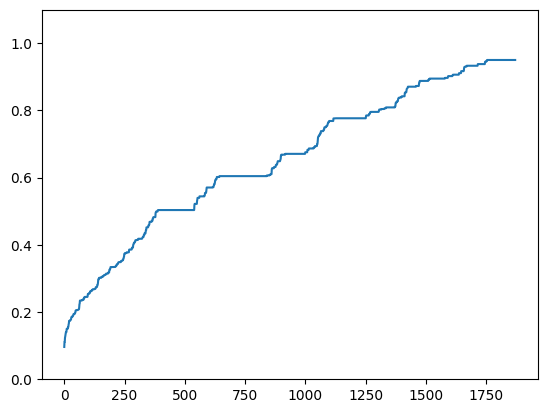

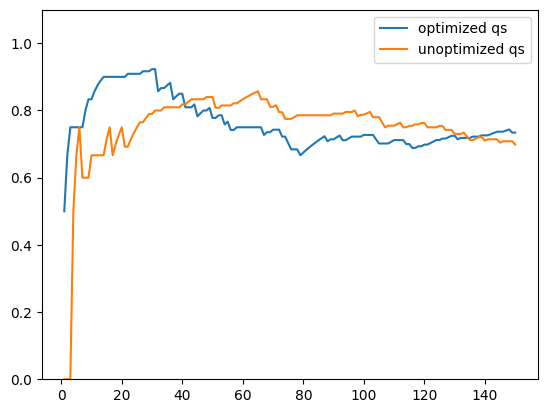

In [309]:
sents = list(random.sample(eng_rus_pairs, 500))
puz_cands = [{
    "source": s_src,
    "target": s_tgt,
    "blanks": inds
} for (s_src, s_tgt) in sents for inds in viable_inds(s_tgt)]
probs = sorted([logistic_puzzle_prob(puz, st) for puz in puz_cands])
plt.plot(list(range(len(probs))), probs)
plt.ylim((0, 1.1))
plt.show()

opti_inds = [q["optimized"] for q in st["questions"]]
rand_inds = [not q["optimized"] for q in st["questions"]]
opti_cumsum = np.cumsum(opti_inds)
rand_cumsum = np.cumsum(rand_inds)
opti_corr_cumsum = np.cumsum([x and y for (x, y) in zip(opti_inds, st["q_results"])])
rand_corr_cumsum = np.cumsum([x and y for (x, y) in zip(rand_inds, st["q_results"])])

cum_scores = [sum(st["q_results"][:(i+1)])/(i+1) for i in range(len(st["q_results"]))]
xs = 1 + np.array(list(range(len(cum_scores))))
# plt.plot(xs, cum_scores)
plt.plot(xs, opti_corr_cumsum/(1+opti_cumsum), label="optimized qs")
plt.plot(xs, rand_corr_cumsum/(1+rand_cumsum), label="unoptimized qs")
plt.ylim((0, 1.1))
# plt.fill_between(xs, 0.5 - 1/np.sqrt(4*xs), 0.5 + 1/np.sqrt(4*xs), alpha=0.3)
plt.legend()
plt.show()

In [312]:
st

attr_scores = sorted(list(zip(st["q_coefs"][1:], [(rf["name"], x) for rf in RUS_FEATURES for x in rf["values"]])), key=lambda x: x[0])
for (score, (attr_name, attr_value)) in attr_scores:
    print(attr_name.ljust(15), "=", attr_value.ljust(15), score)

Degree          = Pos             -0.7838257369483516
POS             = ADJ             -0.6743982655197027
Number          = Plur            -0.5749867691181048
POS             = NOUN            -0.5688819262261002
Animacy         = Anim            -0.4646909561791738
Gender          = Fem             -0.44733962419565343
Dependency      = obl             -0.35029763882554144
Case            = Loc             -0.32441017932604566
Dependency      = det             -0.25246366980077695
Dependency      = amod            -0.23175558163799043
POS             = PROPN           -0.1856010773947545
POS             = DET             -0.1663460118324427
Dependency      = acl:relcl       -0.16405055011962394
Animacy         = Inan            -0.16061738593993682
Case            = Gen             -0.15136790830123262
Dependency      = nmod            -0.146636983735436
Tense           = Past            -0.14645751955837824
Aspect          = Perf            -0.1420605519724294
Dependency      = RO